In [1]:
import pandas as pd
import numpy as np
import os
from google.colab import drive 

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
# to play the audio files
from IPython.display import Audio


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint




In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/empathic_data/data/audio-files/'

Mounted at /content/drive


In [ ]:
filepath = []
file_name = []
total = [] 
for filename in os.listdir(data_path):
    if filename.endswith(".wav"): 
      file_name.append(filename)
      filepath.append(data_path)

In [ ]:
merged_path = [''.join(x) for x in zip(filepath, file_name)]

In [ ]:
dictionary = dict(zip(file_name, merged_path))

In [ ]:
df = pd.read_csv('/content/merged_data.csv')
df['path'] = df['file_name'].map(dictionary)
df['Emotion'] = df['Emotion'].str.capitalize()
df = df[df['Emotion'] != 'Pleasure']
df['Emotion'].replace('Pain', 'Sad', inplace=True)
df['Emotion'].replace('Achievement', 'Happy', inplace=True)
df.head()

,file_name,Speaker,Emotion,Intensity,Dataframe,Duration,Word,Type,Gender,path
0,S04_fear_peak_03.wav,S04,Fear,peak,VIVAE,0.752472,NaN,Sound,NaN,/content/drive/My Drive/empathic_data/data/aud...
3,S04_pain_strong_08.wav,S04,Sad,strong,VIVAE,0.752472,NaN,Sound,NaN,/content/drive/My Drive/empathic_data/data/aud...
4,S04_fear_strong_05.wav,S04,Fear,strong,VIVAE,0.672404,NaN,Sound,NaN,/content/drive/My Drive/empathic_data/data/aud...
5,S08_pain_peak_01.wav,S08,Sad,peak,VIVAE,0.536463,NaN,Sound,NaN,/content/drive/My Drive/empathic_data/data/aud...
6,S06_fear_moderate_03.wav,S06,Fear,moderate,VIVAE,0.752472,NaN,Sound,NaN,/content/drive/My Drive/empathic_data/data/aud...


In [ ]:
print("number of files is {}".format(len(df)))

number of files is 4640


In [ ]:
df.Emotion.replace('Ps','Surprise',inplace=True)

In [ ]:
df.Emotion.unique()

array(['Fear', 'Sad', 'Surprise', 'Angry', 'Happy', 'Calm', 'Disgust'],
      dtype=object)

<Figure size 432x288 with 0 Axes>

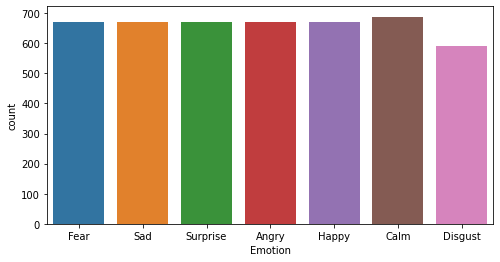

In [ ]:
fig = plt.figure()
plt.figure(figsize=(8, 4))
sns.countplot(x="Emotion", data=df)
plt.show();

In [ ]:
def features_extractor(file,inputfeature):
  if inputfeature == 'mfcc':
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return np.mean(mfccs_features.T,axis=0)

  if inputfeature == 'mel':
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T, axis=0)
    return mel
    #result = np.hstack((result, mel)) # stacking horizontally
    

 
    

In [ ]:
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients

extracted_features=[]
for index_num,row in tqdm(df.iterrows()):
    file_name = row["path"]
    final_class_labels=row["Emotion"]
    data=features_extractor(file_name,'mfcc')
    extracted_features.append([data,final_class_labels])
  

In [ ]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

In [ ]:
#extracted_features_df.to_csv('dataset.csv',index = 'False')
with open('new_mfcc.json', 'w') as f:
  f.write(extracted_features_df.to_json())

In [ ]:
import json
data = json.load(open('/content/mfcc.json'))
df = pd.DataFrame(data)

In [ ]:
df

,feature,class
0,"[-388.544128418, -21.1369800568, -122.90878295...",Fear
1,"[-484.0332336426, 54.4067153931, -46.810455322...",Sad
2,"[-352.4352111816, 28.341053009, -80.774269104,...",Fear
3,"[-334.7111206055, 4.2237181664, -143.995819091...",Sad
4,"[-455.1717529297, 64.6031799316, -26.945173263...",Fear
...,...,...
4635,"[-529.6136474609, 58.8643531799, -9.316198349,...",Fear
4636,"[-335.4749755859, 55.7228393555, -29.179220199...",Fear
4637,"[-512.0512084961, 62.8047599792, -19.674118042...",Disgust
4638,"[-520.8950195312, 77.6130599976, -10.199032783...",Disgust


In [ ]:
### Split the dataset into independent and dependent dataset
X=np.array(df['feature'].tolist())
y=np.array(df['class'].tolist())

In [ ]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [ ]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3712, 40), (928, 40), (3712, 7), (928, 7))

In [ ]:
from keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau, ModelCheckpoint

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 4,
                          verbose = 1,
                          restore_best_weights = True)

filename = 'traindataepoch.csv'
csv_logger = CSVLogger(filename,separator = ",", append =True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.1,
                              patience = 3,
                              min_lr = 0.001)

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               save_best_only = True,
                               verbose=1)

In [ ]:
#@title CNN Model
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten, LSTM,Bidirectional,TimeDistributed

model = Sequential()

# input and first hidden layer
model.add(Dense(input_shape=(40,), units=256, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))

# second hidden layer
model.add(Dense(units=256,activation='relu',kernel_initializer='uniform'))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))

# compiling our model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(7))
model.add(Activation('softmax'))

# compiling our model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 40, 256)           1536      
                                                                 
 activation_7 (Activation)   (None, 40, 256)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 40, 128)           163968    
                                                                 
 activation_8 (Activation)   (None, 40, 128)           0         
                                                                 
 dropout_5 (Dropout)         (None, 40, 128)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                      

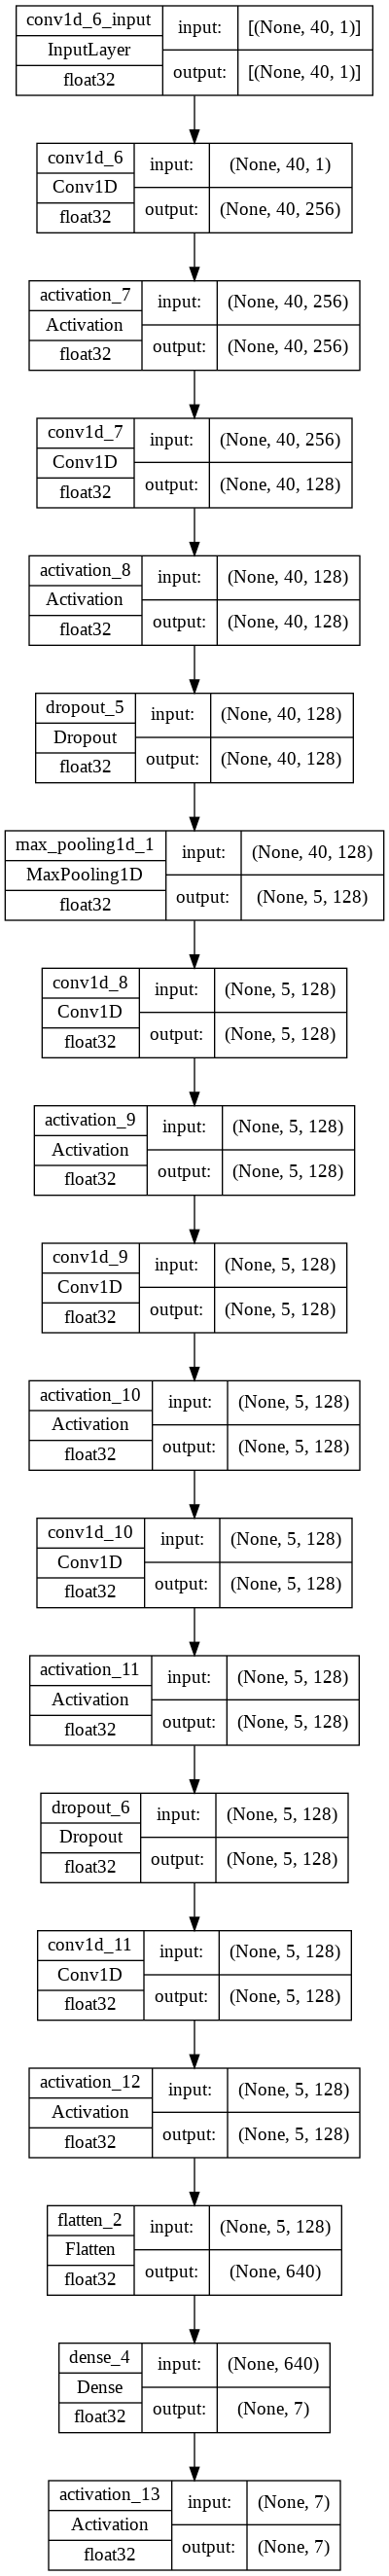

In [ ]:
keras.utils.plot_model(model, show_dtype=True, 
                       show_layer_names=True, show_shapes=True,  
                       to_file='model.png')

In [ ]:
## Training my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer,earlystop,csv_logger,reduce_lr], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
116/116 [==============================] - ETA: 0s - loss: 1.4691 - accuracy: 0.4494
Epoch 1: val_loss improved from inf to 0.98030, saving model to saved_models/audio_classification.hdf5
116/116 [==============================] - 10s 77ms/step - loss: 1.4691 - accuracy: 0.4494 - val_loss: 0.9803 - val_accuracy: 0.6530 - lr: 0.0010
Epoch 2/100
116/116 [==============================] - ETA: 0s - loss: 0.9508 - accuracy: 0.6501
Epoch 2: val_loss improved from 0.98030 to 0.90157, saving model to saved_models/audio_classification.hdf5
116/116 [==============================] - 9s 77ms/step - loss: 0.9508 - accuracy: 0.6501 - val_loss: 0.9016 - val_accuracy: 0.6616 - lr: 0.0010
Epoch 3/100
116/116 [==============================] - ETA: 0s - loss: 0.7951 - accuracy: 0.7015
Epoch 3: val_loss improved from 0.90157 to 0.77149, saving model to saved_models/audio_classification.hdf5
116/116 [==============================] - 9s 74ms/step - loss: 0.7951 - accuracy: 0.7015 - val_loss:

In [ ]:
loss, acc = model.evaluate(X_test,y_test)
print("Model Accuracy: {:5.2f}%".format(100*acc))
print("Model Loss: {:5.2f}".format(loss))

29/29 [==============================] - 0s 17ms/step - loss: 0.5397 - accuracy: 0.8136
Model Accuracy: 81.36%
Model Loss:  0.54


In [ ]:
print(model.evaluate(X_train,y_train))

116/116 [==============================] - 2s 16ms/step - loss: 0.3748 - accuracy: 0.8747
[0.3748457133769989, 0.8747305870056152]


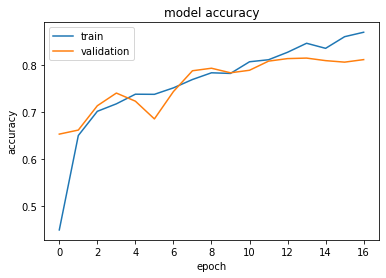

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

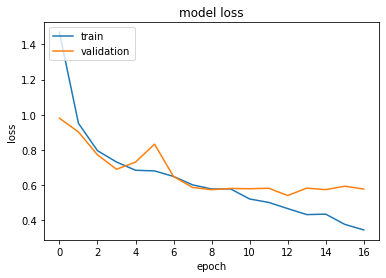

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [ ]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

model_results = pd.DataFrame()
model_results['epochs'] = range(1,12)
model_results['loss'] = loss
model_results['accuracy'] = accuracy
model_results['val_loss'] = val_loss
model_results['val_accuracy'] = val_accuracy

In [ ]:
model_results

,epochs,loss,accuracy,val_loss,val_accuracy
0,1,3.396842,0.184806,1.799520,0.399784
1,2,1.602592,0.357220,1.231445,0.515086
2,3,1.300895,0.498384,1.058403,0.661638
3,4,1.145158,0.561422,0.864152,0.699353
4,5,1.053775,0.594558,0.815788,0.697198
5,6,0.971047,0.623384,0.764726,0.721983
6,7,0.940529,0.642780,0.745523,0.718750
7,8,0.915344,0.653825,0.734519,0.747845
8,9,0.882983,0.665679,0.710636,0.745690
9,10,0.862336,0.677263,0.683306,0.746767


In [ ]:
X_test[1]

array([-375.85068  ,   86.35763  ,   21.226683 ,   45.644417 ,
         -8.248565 ,    4.1287   ,  -10.461711 ,   -5.7135344,
         -5.52071  ,   -5.5966673,  -12.4093895,    7.144957 ,
        -14.895025 ,   12.311402 ,  -10.67461  ,    1.0261024,
         -2.1982286,   -2.3116531,  -11.516636 ,   -4.127701 ,
         -7.912048 ,   -4.475407 ,   -1.9440111,    6.2645283,
          1.1150794,    5.031153 ,   -1.2491494,   -3.7283168,
         -3.8071969,   -0.8560266,    4.8278956,   10.012675 ,
          6.9030924,    2.5040138,    1.7965624,    3.612148 ,
          5.591348 ,    7.4673133,   10.107303 ,    7.6095343],
      dtype=float32)

In [ ]:
y_test[1]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

29/29 [==============================] - 1s 18ms/step


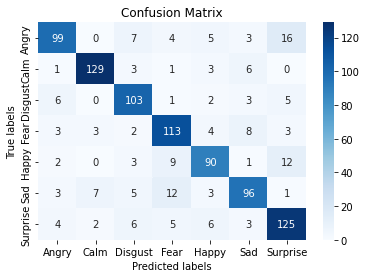

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
matrix = confusion_matrix(y_test,y_pred)

ax= plt.subplot()
sns.heatmap(matrix, linecolor='white', cmap='Blues', annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Angry','Calm','Disgust','Fear','Happy','Sad','Surprise'])
ax.yaxis.set_ticklabels(['Angry','Calm','Disgust','Fear','Happy','Sad','Surprise']);

In [ ]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred, average='macro'))

0.812057623589166


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
y_test_inverse = labelencoder.inverse_transform(y_test)
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df['Labels'] = y_test_inverse.flatten()
df.tail(11)

,Predicted Labels,Actual Labels,Labels
917,1,1,Calm
918,5,5,Sad
919,2,2,Disgust
920,3,3,Fear
921,4,4,Happy
922,1,2,Disgust
923,1,1,Calm
924,2,2,Disgust
925,6,5,Sad
926,4,6,Surprise


In [ ]:
num = [0,1,2,3,4,5,6,7]
emotions = ['Angry','Calm','Disgust','Fear','Happy','Sad','Surprise']

In [ ]:
label = dict(zip(num, emotions))

In [ ]:
print(classification_report(y_test, y_pred,target_names=['Angry','Calm','Disgust','Fear','Happy','Sad','Surprise']))

              precision    recall  f1-score   support

       Angry       0.84      0.74      0.79       134
        Calm       0.91      0.90      0.91       143
     Disgust       0.80      0.86      0.83       120
        Fear       0.78      0.83      0.80       136
       Happy       0.80      0.77      0.78       117
         Sad       0.80      0.76      0.78       127
    Surprise       0.77      0.83      0.80       151

    accuracy                           0.81       928
   macro avg       0.81      0.81      0.81       928
weighted avg       0.82      0.81      0.81       928



In [ ]:
model.save('baseline_cnn_20/my_model') 

In [6]:
loaded_model = tf.keras.models.load_model('/content/_baseline_cnn_20_keras_metadata.pb')

OSError: ignored